In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech
print(malaya_speech.__version__)
from pysptk import sptk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pyworld as pw

1.0.3


In [3]:
vggvox_v2 = malaya_speech.gender.deep_model(model = 'vggvox-v2')
speaker_model = malaya_speech.speaker_vector.deep_model('vggvox-v2')

In [4]:
freqs = {'female': [100, 600], 'male': [50, 250]}

In [5]:
from scipy.signal import get_window
from scipy import signal
import soundfile as sf
import random

sr = 22050

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b, a = butter_highpass(30, sr, order=5)

In [6]:
from math import ceil

def quantize_f0_numpy(x, num_bins = 256):
    # x is logf0
    assert x.ndim == 1
    x = x.astype(float).copy()
    uv = x <= 0
    x[uv] = 0.0
    x = np.round(x * (num_bins - 1))
    x = x + 1
    x[uv] = 0.0
    enc = np.zeros((len(x), num_bins + 1), dtype = np.float32)
    enc[np.arange(len(x)), x.astype(np.int32)] = 1.0
    return enc, x.astype(np.int64)

def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

def speaker_normalization(f0, index_nonzero, mean_f0, std_f0):
    f0 = f0.astype(float).copy()
    f0[index_nonzero] = (f0[index_nonzero] - mean_f0) / std_f0 / 4.0
    f0[index_nonzero] = np.clip(f0[index_nonzero], -1, 1)
    f0[index_nonzero] = (f0[index_nonzero] + 1) / 2.0
    return f0

def preprocess_wav(x):
    if x.shape[0] % 256 == 0:
        x = np.concatenate((x, np.array([1e-06])), axis=0)
    y = signal.filtfilt(b, a, x)
    wav = y * 0.96 + (np.random.uniform(size = y.shape[0]) - 0.5)*1e-06
    return wav

def get_f0_sptk(wav, lo, hi):
    f0_rapt = sptk.rapt(wav.astype(np.float32)*32768, sr, 256, min=lo, max=hi, otype=2)
    index_nonzero = (f0_rapt != -1e10)
    mean_f0, std_f0 = np.mean(f0_rapt[index_nonzero]), np.std(f0_rapt[index_nonzero])
    return speaker_normalization(f0_rapt, index_nonzero, mean_f0, std_f0)

def get_fo_pyworld(wav):
    x = wav
    _f0, t = pw.dio(wav, sr,
                    f0_ceil=7600,
                   frame_period=1000 * 256 / sr,
                   )
    f0_rapt = pw.stonemask(x.astype(np.double), _f0, t, sr)
    index_nonzero = (f0_rapt != 0.0)
    mean_f0, std_f0 = np.mean(f0_rapt[index_nonzero]), np.std(f0_rapt[index_nonzero])
    return speaker_normalization(f0_rapt, index_nonzero, mean_f0, std_f0)

def pad_seq(x, base = 8):
    len_out = int(base * ceil(float(x.shape[0]) / base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0, len_pad), (0, 0)), 'constant'), x.shape[0]

def get_speech(f, use_sptk = True, hop_size = 256):
    x, fs = malaya_speech.load(f, sr = sr)
    wav = preprocess_wav(x)
    x_16k = malaya_speech.resample(x, sr, 16000)
    if use_sptk:
        gender = vggvox_v2(x_16k)
        print(gender)
        lo, hi = freqs.get(gender, [50, 250])
        f0 = get_f0_sptk(wav, lo, hi)
    else:
        f0 = get_fo_pyworld(wav)
    f0 = np.expand_dims(f0, -1)
    mel = malaya_speech.featurization.universal_mel(wav)
    
#     batch_max_steps = random.randint(16384, 77175)
#     batch_max_frames = batch_max_steps // hop_size
    
#     if len(mel) > batch_max_frames:
#         interval_start = 0
#         interval_end = len(mel) - batch_max_frames
#         start_frame = random.randint(interval_start, interval_end)
#         start_step = start_frame * hop_size
#         wav = wav[start_step : start_step + batch_max_steps]
#         mel = mel[start_frame : start_frame + batch_max_frames, :]
#         f0 = f0[start_frame : start_frame + batch_max_frames, :]
        
    wav_16k = malaya_speech.resample(wav, sr, 16000)
    v = speaker_model([wav_16k])[0]
    v = v / v.max()
    return wav, mel, f0, v

In [7]:
from glob import glob

haqkiem = glob('/home/husein/speech-bahasa/haqkiem/*.wav')
turki = glob('/home/husein/speech-bahasa/turki/*/*.wav')
dari_pasentran = glob('/home/husein/speech-bahasa/dari-pasentran-ke-istana/*/*.wav')
salina = glob('/home/husein/speech-bahasa/salina/*/*.wav')

In [8]:
index = 4
l = 'khalil-nooh.wav'
l = haqkiem[index]
r = salina[index]
# r = 'shafiqah-idayu.wav'

In [9]:
import IPython.display as ipd
ipd.Audio(l)

In [10]:
ipd.Audio(r)

In [11]:
wav, mel, f0, v = get_speech(l)
wav_1, mel_1, f0_1, v_1 = get_speech(r)

female
female


In [12]:
mels, mel_lens = malaya_speech.padding.sequence_nd([mel, mel_1], dim = 0, return_len = True)
mels.shape, mel_lens

((2, 830, 80), [709, 830])

In [13]:
f0s, f0_lens = malaya_speech.padding.sequence_nd([f0, f0_1], dim = 0, return_len = True)
f0s.shape, f0_lens

((2, 830, 1), [709, 830])

In [14]:
f0_org_quantized = quantize_f0_numpy(f0s[0,:,0])[0]
f0_org_onehot = f0_org_quantized[np.newaxis, :, :]
uttr_f0_org = np.concatenate([mels[:1], f0_org_onehot], axis = -1)
f0_trg_quantized = quantize_f0_numpy(f0s[1,:,0])[0]
f0_trg_onehot = f0_trg_quantized[np.newaxis, :, :]

In [15]:
X = tf.placeholder(tf.float32, [None, None, 80], name = 'X')
len_X = tf.placeholder(tf.int32, [None], name = 'len_X')
V = tf.placeholder(tf.float32, [None, 512], name = 'V')
f0_onehot = tf.placeholder(tf.float32, [None, None, 257], name = 'f0_onehot')
uttr_f0 = tf.placeholder(tf.float32, [None, None, 337], name = 'uttr_f0')

In [16]:
from malaya_speech.train.model.fastspeechsplit import inference as fastspeechsplit
from malaya_speech.train.model import speechsplit, fastspeech

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [17]:
hparams = speechsplit.hparams
config = malaya_speech.config.fastspeech_config
config = fastspeech.Config(vocab_size = 1, **config)
interplnr = speechsplit.InterpLnr(hparams)
model = fastspeechsplit.Model(config, hparams)
model_F0 = fastspeechsplit.Model_F0(config, hparams)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
bottleneck_speaker = tf.keras.layers.Dense(hparams.dim_spk_emb)
speaker_dim = bottleneck_speaker(V)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
codes_x, codes_f0, codes_2, encoder_outputs, mel_outputs = model(uttr_f0, X, speaker_dim, 
                                                                 len_X, training = True)

In [20]:
_, _, _, f0_target = model_F0(X, f0_onehot, len_X, training = True)

In [21]:
mel_outputs = tf.identity(mel_outputs, name = 'mel_outputs')
f0_target = tf.identity(f0_target, name = 'f0_target')

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:
path = 'fastspeechsplit-vggvox-v2-crossentropy'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'fastspeechsplit-vggvox-v2-crossentropy/model.ckpt-1020000'

In [24]:
saver = tf.train.Saver(var_list = tf.trainable_variables())
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from fastspeechsplit-vggvox-v2-crossentropy/model.ckpt-1020000


INFO:tensorflow:Restoring parameters from fastspeechsplit-vggvox-v2-crossentropy/model.ckpt-1020000


In [25]:
f0_pred = sess.run(f0_target, feed_dict = {
    X: mels[:1], f0_onehot: f0_trg_onehot, len_X: [len(f0_trg_onehot[0])]
})
f0_pred.shape

(1, 830, 257)

In [26]:
f0_pred_quantized = f0_pred.argmax(axis=-1).squeeze(0)
f0_con_onehot = np.zeros_like(f0_pred)
f0_con_onehot[0, np.arange(f0_pred.shape[1]), f0_pred_quantized] = 1
uttr_f0_trg = np.concatenate([mels[:1], f0_con_onehot], axis=-1)

In [27]:
# G(uttr_f0_org, uttr_trg_pad, emb_org)
x_identic_val_R = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_org,
                                                  X: mels[1:], V: [v], len_X: [len(uttr_f0_org[0])]})
x_identic_val_R.shape

(1, 830, 80)

In [28]:
# G(uttr_f0_trg, uttr_org_pad, emb_org)
x_identic_val_F = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[:1], V: [v], len_X: [len(uttr_f0_trg[0])]})
x_identic_val_F.shape

(1, 830, 80)

In [29]:
# G(uttr_f0_org, uttr_org_pad, emb_trg)
x_identic_val_U = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_org,
                                                  X: mels[:1], V: [v_1], len_X: [len(uttr_f0_org[0])]})
x_identic_val_U.shape

(1, 830, 80)

In [30]:
# G(uttr_f0_trg, uttr_trg_pad, emb_org)
x_identic_val_RF = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[1:], V: [v], len_X: [len(uttr_f0_trg[0])]})
x_identic_val_RF.shape

(1, 830, 80)

In [31]:
# G(uttr_f0_org, uttr_trg_pad, emb_trg)
x_identic_val_RU = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_org,
                                                  X: mels[1:], V: [v_1], len_X: [len(uttr_f0_org[0])]})
x_identic_val_RU.shape

(1, 830, 80)

In [32]:
# G(uttr_f0_trg, uttr_org_pad, emb_trg)
x_identic_val_FU = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[:1], V: [v_1], len_X: [len(uttr_f0_trg[0])]})
x_identic_val_FU.shape

(1, 830, 80)

In [33]:
# G(uttr_f0_trg, uttr_trg_pad, emb_trg)
x_identic_val_RFU = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[1:], V: [v_1], len_X: [len(uttr_f0_trg[0])]})
x_identic_val_RFU.shape

(1, 830, 80)

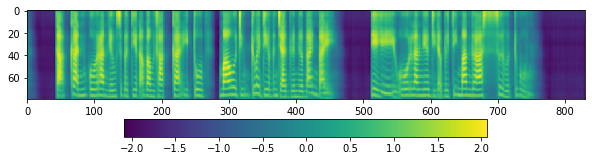

In [34]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_R[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

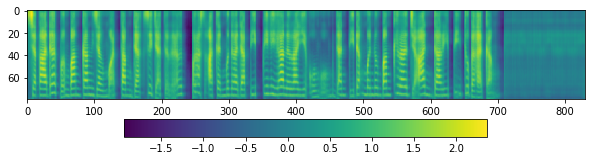

In [35]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_F[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

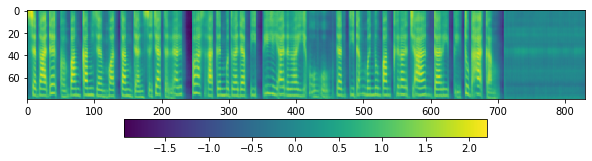

In [36]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_U[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

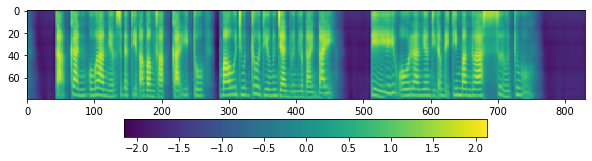

In [37]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_RF[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

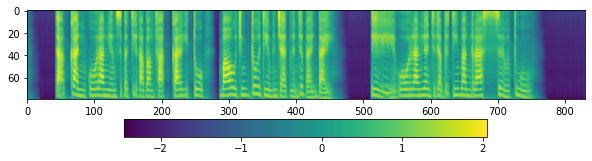

In [38]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_RU[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

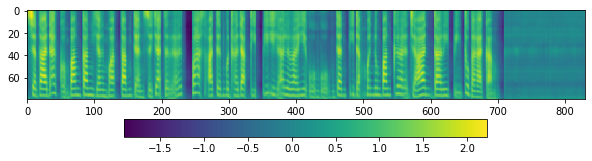

In [39]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_FU[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

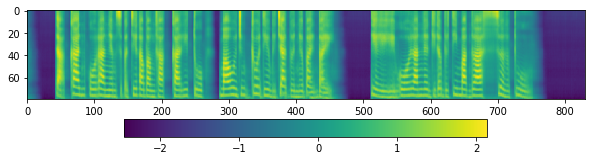

In [40]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_RFU[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [41]:
import pickle

with open('a.pkl', 'wb') as fopen:
    pickle.dump([x_identic_val_R[0], x_identic_val_F[0], x_identic_val_U[0],
                x_identic_val_RF[0], x_identic_val_RU[0], x_identic_val_FU[0],
                x_identic_val_RFU[0]], fopen)

In [42]:
saver = tf.train.Saver()
saver.save(sess, 'fastspeechsplit-pysptk/model.ckpt')

'fastspeechsplit-pysptk/model.ckpt'

In [43]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'mel_' in n.name
        or 'X' in n.name
        or 'V' in n.name
        or 'f0' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
        and 'IsInitialized' not in n.name
    ]
)

In [44]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [45]:
freeze_graph('fastspeechsplit-pysptk', strings)

INFO:tensorflow:Restoring parameters from fastspeechsplit-pysptk/model.ckpt


INFO:tensorflow:Restoring parameters from fastspeechsplit-pysptk/model.ckpt


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Froze 382 variables.


INFO:tensorflow:Froze 382 variables.


INFO:tensorflow:Converted 382 variables to const ops.


INFO:tensorflow:Converted 382 variables to const ops.


7900 ops in the final graph.


In [46]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [47]:
g = load_graph('fastspeechsplit-pysptk/frozen_model.pb')

In [48]:
from tensorflow.tools.graph_transforms import TransformGraph
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [49]:
pb = 'fastspeechsplit-pysptk/frozen_model.pb'
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['X', 'len_X', 'V', 'f0_onehot', 'uttr_f0'],
                                           ['mel_outputs', 'f0_target'], transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


Instructions for updating:
Use tf.gfile.GFile.
